# This notebook analyzes the R(E) error traces for the $E_0=50$ keV, $J_0=1E4$ exponential spectra

In [1]:
import h5py
import re
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors
import itertools
%matplotlib inline
import copy

/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


It loads in the dictionaries in the "2018_07_13_rerr_traces.h5" file, and then calculates the mean and credible intervals for the E0 and J0 parameters as a function of the FWHM error on the response amplitude and energy shift

In [2]:
def key2val(key):
    """
    This function reads in the resonse error keys and 
    returns the FWHM percentiles. 
    """
    return tuple(map(int, re.findall(r'\d+', key)))

In [3]:
def printKeys(hf):
    print('Data run,    trace keys')
    for keys in hf.keys():
        print(keys, list(hf[keys].keys()))

Open the h5 file and do statistics on it.

In [4]:
file = '2018-07-16_rerr_traces.h5'

with h5py.File(file, 'r') as hf:
    #printKeys(hf)
    fKeys = list(hf.keys())
    
    runKeys = list(filter(lambda x: x != 'GLOBAL', hf.keys())) # Ignore global params.
    statDict = {'FWHM_R':np.zeros_like(runKeys, dtype=int), 
                'FWHM_E':np.zeros_like(runKeys, dtype=int),
               'E0_mu':np.zeros_like(runKeys, dtype=float),
                'J0_mu':np.zeros_like(runKeys, dtype=float),
                'E0_ci':np.zeros((len(runKeys), 2), dtype=float),
                'J0_ci':np.zeros((len(runKeys), 2), dtype=float)
               }
    #print(list(hf['GLOBAL'].keys()))
    #print(hf['GLOBAL']['TRUE_E0'][0])
    #statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0']
    for i, errSet in enumerate(runKeys): 
        statDict['FWHM_R'][i], statDict['FWHM_E'][i] = key2val(errSet)
        statDict['E0_mu'][i] = np.mean(hf[errSet]['E0'])
        statDict['J0_mu'][i] = np.mean(hf[errSet]['J0'])
        statDict['E0_ci'][i, :] = np.percentile(hf[errSet]['E0'], (2.5, 97.5))
        statDict['J0_ci'][i, :] = np.percentile(hf[errSet]['J0'], (2.5, 97.5))
    statDict['TRUE_E0'] = hf['GLOBAL']['TRUE_E0'].value
    statDict['TRUE_J0'] = hf['GLOBAL']['TRUE_J0'].value

### Visualize the mean $E_0$ and $J_0$ values along the diagonal errors 
(The same FWHM values for both the amplitude and energy R(E) uncertainty)

In [5]:
# Get index array of diagonal elements.
diagInd = np.where(statDict['FWHM_R'] == statDict['FWHM_E'])[0] 
yerr_E0 = np.abs(statDict['E0_ci'][diagInd]-
                 np.repeat(statDict['E0_mu'][diagInd, np.newaxis], 2, axis=1)).T
yerr_J0 = np.abs(statDict['J0_ci'][diagInd]-
                 np.repeat(statDict['J0_mu'][diagInd, np.newaxis], 2, axis=1)).T

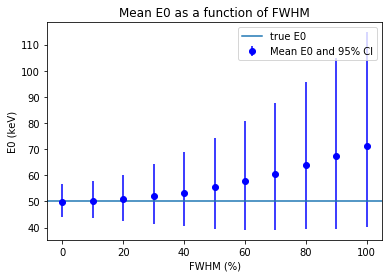

In [6]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['E0_mu'][diagInd], 
             yerr=yerr_E0, fmt='bo', label='Mean E0 and 95% CI');
plt.axhline(statDict['TRUE_E0'], label='true E0');
plt.title('Mean E0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('E0 (keV)'); plt.legend(); 
plt.savefig('2018-07-13_uniform_prior_mean_E0.png', dpi=300)

In [7]:
plt.errorbar(statDict['FWHM_R'][diagInd], statDict['J0_mu'][diagInd], 
             yerr=yerr_J0, fmt='bo', label='Mean J0 and 95% CI');
plt.axhline(statDict['TRUE_J0'], label='true J0');
plt.title('Mean J0 as a function of FWHM'); plt.xlabel('FWHM (%)'); 
plt.ylabel('J0'); plt.legend();
plt.savefig('2018-07-13_uniform_prior_mean_J0.png', dpi=300)

### Now visualize the relative error of the mean values of the traces using a mesh plot in the entire FWHM uncertainty space

In [8]:
RR, EE = np.meshgrid(sorted(list(set(statDict['FWHM_R'])) + [110]), 
                     sorted(list(set(statDict['FWHM_E']))) + [110])

In [9]:
C_E = np.nan*np.ones_like(RR)
C_J = np.nan*np.ones_like(RR)

for i, key in enumerate(runKeys):
    Rn, En = key2val(key)
    idx = np.where((Rn == RR) & (En == EE))
    C_E[idx[0][0], idx[1][0]] = 100*(statDict['E0_mu'][i]-
                                     statDict['TRUE_E0'])/statDict['TRUE_E0']
    C_J[idx[0][0], idx[1][0]] = 100*(statDict['J0_mu'][i]-
                                     statDict['TRUE_J0'])/statDict['TRUE_J0']


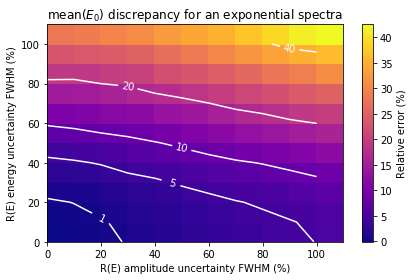

In [10]:
p = plt.pcolormesh(RR, EE, C_E, vmin=np.nanmin(C_E), vmax=np.nanmax(C_E), cmap='plasma');
c = plt.contour(RR, EE, C_E, levels=[1, 5, 10, 20, 40, 60], colors='w')
plt.clabel(c, c.levels, inline=True, fmt='%2d', fontsize=10)
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($E_0$) discrepancy for an exponential spectra');
plt.tight_layout()
#plt.savefig('mean_E0_discrepancy_fwhm.png', dpi=300)

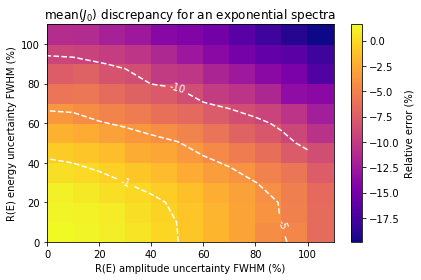

In [11]:
p = plt.pcolormesh(RR, EE, C_J, vmin=np.nanmin(C_J), vmax=np.nanmax(C_J), cmap='plasma');
c = plt.contour(RR, EE, C_J, levels=[-20, -10, -5, -1], colors='w')
plt.clabel(c, c.levels, inline=True, fmt='%2d', fontsize=10)
plt.colorbar(p, label='Relative error (%)'); 
plt.xlabel('R(E) amplitude uncertainty FWHM (%)');
plt.ylabel('R(E) energy uncertainty FWHM (%)');
plt.title(r'mean($J_0$) discrepancy for an exponential spectra');
plt.tight_layout()
#plt.savefig('mean_J0_discrepancy_fwhm.png', dpi=300)

### Statistics of the J0 and E0 distributions that are consistant with the observed counts for a few values of FWHM.

Now we calculate the statistics of 100 spectra drawn from a few FWHM traces(mean, 2.5%, and 95% credible interval) as a function of energy. The keys list controls which FWHM values to plot.

First, get a few traces from the trace file.

In [12]:
traces = {}
keys = ['RERR00_EERR00', 'RERR50_EERR50', 'RERR100_EERR100']
with h5py.File(file, 'r') as hf:
    for key in keys:
        traces[key] = {}
        traces[key]['E0'] = hf[key]['E0'].value
        traces[key]['J0'] = hf[key]['J0'].value

In [13]:
def spectra(E, J0, E0):
    return J0*np.exp(-E/E0)

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [15]:
E = np.arange(20,300)
nS = 100
random_samples = np.random.randint(0, len(traces[keys[0]]['E0']), nS)
# dist = np.zeros((len(E), nS, len(keys)), dtype=float)
# for (ik, key) in enumerate(keys):
#     for (i, s) in enumerate(random_samples):
#         for e in range(len(E)):
#             dist[e, i, ik] = spectra(E, traces[key]['J0'][s], traces[key]['E0'][s])[e]
fSpec = {}
dist = {}
for key in keys:
    fSpec[key] = np.array([spectra(E, Ji, Ei) 
                      for Ji, Ei in zip(traces[key]['J0'], traces[key]['E0'])]).T
    dist[key] = fSpec[key][:, random_samples]

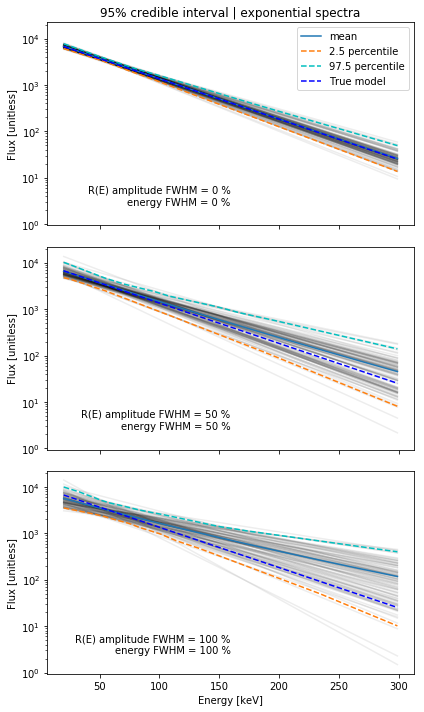

In [17]:
f, axArr = plt.subplots(len(keys), figsize=(6, 10), sharex=True, sharey=True)

for ia, ax in enumerate(axArr):
    for i in random_samples:
        ax.plot(E, spectra(E, traces[keys[ia]]['J0'][i], traces[keys[ia]]['E0'][i]), 
                 c='k', alpha=0.07)
    ax.plot(E, np.mean(dist[keys[ia]], axis=1), label='mean');
    ax.plot(E, np.percentile(dist[keys[ia]], 2.5, axis=1), '--', 
            label='2.5 percentile')
    ax.plot(E, np.percentile(dist[keys[ia]], 97.5, axis=1), '--', 
            label='97.5 percentile', c='c')
    ax.plot(E, spectra(E, statDict['TRUE_J0'], statDict['TRUE_E0']), 'b--', 
            label='True model')
    ax.set_yscale('log'); ax.set_ylabel('Flux [unitless]'); 
    
    s = 'R(E) amplitude FWHM = {} %\nenergy FWHM = {} %'.format(*key2val(keys[ia]))
    ax.text(s=s, x=0.5, y=0.1, transform=ax.transAxes, ha='right')
    
ax.set_xlabel('Energy [keV]');
    
axArr[0].legend()
axArr[0].set_title('95% credible interval | exponential spectra');
plt.tight_layout() 
#plt.savefig('exp_spectra_fwhm_ci.png', dpi=300)

### Now calculate the CI(E)
for the different FWHM uncertainty and investigate how it depends on the % error, and where the minimum error is.

In [ ]:
CI = np.nan*np.zeros((len(E), 2, len(keys)))
mu = np.nan*np.zeros((len(E), len(keys)))

for i in range(len(keys)):
    CI[:,0,i] = np.percentile(dist[:, :, i], 2.5, axis=1)
    CI[:,1,i] = np.percentile(dist[:, :, i], 97.5, axis=1)
    mu[:, i] = np.mean(dist[:, :, i], axis=1)

Plot how the CI depends on energy for the FWHM error values in the keys dictionary

In [ ]:
for i, errKey in enumerate(keys):
    plt.semilogy(E, (CI[:,1,i] - CI[:,0,i]), label=errKey);   
    plt.legend(); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');
    plt.title('CI width as a function of energy '
             '\n exponential spectra | E_0={} keV | J_0={}'.format(
             statDict['TRUE_E0'], statDict['TRUE_J0']));

Interesting that there is a break in the uncertanity at the e-folding energy. Not sure why this happens. Lets try to normalize these curves by J(E). The curves below show the relative flux error as a function of energy, which is minimum at the E-folding energy.

In [ ]:
for i, errKey in enumerate(keys):
    plt.semilogy(E, (CI[:,1,i] - CI[:,0,i])/mu[:,i], label=errKey);   
    plt.legend(); plt.xlabel('Energy (keV)'); plt.ylabel('CI / mu');
    plt.title('CI of possible fluxes, normalized by mean flux'
             '\n exponential spectra | E_0={} keV | J_0={}'.format(
             statDict['TRUE_E0'], statDict['TRUE_J0']));

THINK ABOUT THIS!

My guess is that the minimum occurs at the E-folding energy (even with no uncerainity on R(E)!) because:
    - At $E < E_0$, there is a lot of flux, so the statistical uncertainity is relatively small
    - And at $E < E_0$, there is relatively less flux, so the uncertainity is larger. Now try to prove this with a simple Monte Carlo sim 

Try to reproduce this kink with a simple Monte-Carlo simulation. This does not seem to reproduce the kink, it is due to something else.

In [ ]:
# Pick random E0 vals around the true value
Ep = np.abs(np.random.normal(statDict['TRUE_E0'], statDict['TRUE_E0']/5, size=500))
Jp = np.abs(np.random.normal(statDict['TRUE_J0'], 0.5*statDict['TRUE_J0'], size=500))

Jtest = np.array([Ji*np.exp(-E/Ei) for Ji, Ei in zip(Jp, Ep)]).T
CI = np.percentile(Jtest, 97.5, axis=1) - np.percentile(Jtest, 2.5, axis=1)
mu = np.mean(Jtest, axis=1)

In [ ]:
for i in np.random.randint(0, len(Ep), size=50):
    plt.semilogy(E, Jtest[:, i], 'k', alpha=0.1)
plt.semilogy(E, spectra(E, statDict['TRUE_J0'], statDict['TRUE_E0']), 
             'r--', lw=3);

In [ ]:
plt.semilogy(E, CI/mu);